**ЗАДАЧА 1. A/B тест**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Перечень обязательных вопросов (может быть больше):
-На какие метрики Вы смотрите в ходе анализа и почему?
-Имеются ли различия в показателях и с чем они могут быть связаны?
-Являются ли эти различия статистически значимыми?
-Стоит ли запускать новую механику на всех пользователей?

In [1]:
#импортируем библиотеки, смотрим данные
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import urllib
import json
from urllib.parse import urlencode

plt.style.use('dark_background')
from IPython.display import display_html 

In [2]:
#файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
#(А – контроль, B – целевая группа)
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
groups = pd.read_csv(download_url, sep = ';')
groups.head(4)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B


In [3]:
#проверим ДФ на пустые значения
groups.isnull().sum()

id     0
grp    0
dtype: int64

In [4]:
groups.shape

(74484, 2)

In [5]:
groups.nunique()
#Повторов нет

id     74484
grp        2
dtype: int64

In [6]:
#дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
groups_add = pd.read_csv(download_url, sep = ',')
groups_add.head(4)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B


In [7]:
groups_add.isnull().sum()

id     0
grp    0
dtype: int64

In [8]:
groups_add.shape

(92, 2)

In [9]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [10]:
#Объединим ДФы group и groups_add, чтобы получить данные обо всех пользователях
all_groups = pd.concat([groups, groups_add])
all_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [11]:
all_groups.shape
#74576 = 74484 + 92 - потерянных при объединении данных нет

(74576, 2)

In [12]:
#Посмотрим на долю контрольной и тестовой групп
all_groups.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

По итогу получен достаточно неожиданный результат. Доля целевой группы больше контрольной и составляет 80%. Не очень понятно, почему новый продукт аппробировали на 80% пользователей. 
В данной ситуации оптимальные доли контрольной и тестовой выборок были бы 50%/50%. В этом случае мощность теста была бы максимальная (по сравнению с другими соотношениями размеров выборок контрольной и тестовой групп), кроме того, мы бы не рисковали применить плохое новвоведение на дополнительных 30% пользователей.

In [13]:
#файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
active_studs = pd.read_csv(download_url, sep = ',')
active_studs.head(4)

,student_id
0,581585
1,5723133
2,3276743
3,4238589


In [14]:
active_studs.isnull().sum()

student_id    0
dtype: int64

In [15]:
active_studs.shape

(8341, 1)

In [16]:
active_studs.nunique()

student_id    8341
dtype: int64

По условию задачи А/B тест проводится с целью оценки новой механики оплаты на сайте. Для дальнейшего статистического анализа нас интересуют только те данные, которые были получены в ходе эксперимента. Т.е. нас интересуют только те пользователи, которые заходили на платформу в день проведения эксперимента. 

In [17]:
#Переименуем колонку для удобства дальнейшего объединия
active_studs = active_studs.rename(columns={'student_id' : 'id'})
active_studs.head(1)

,id
0,581585


In [18]:
#Объединяем данные, оставляя пользователей, которые заходили на платформу в день эксперимента
exp_groups = active_studs.merge(all_groups, how='left')
exp_groups

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [19]:
exp_groups.grp.value_counts(normalize=True)

B    0.81561
A    0.18439
Name: grp, dtype: float64

In [20]:
#файл с информацией об оплатах пользователей в дни проведения эксперимента
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
checks = pd.read_csv(download_url, sep = ';')
checks.head(4)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0


In [21]:
checks.isnull().sum()

student_id    0
rev           0
dtype: int64

In [22]:
checks.shape

(541, 2)

In [23]:
checks.student_id.nunique()

541

In [24]:
#Повторяющихся пользователей нет, можно объединять с ДФ exp-groups
checks = checks.rename(columns = {'student_id' : 'id'})
checks.head(3)

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [25]:
df = exp_groups.merge(checks, how='left', on = 'id')
df

,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


In [26]:
#Предположительно, в дальнейшем потребуется рассчитывать средние значения по показателю revenue, 
#соответственно, следует заменить пустые значения на 0
df = df.fillna(0)
df.head(5)

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0



Основной показатель, который нас интересует это общая выручка компании. Соответственно, в рамках оценки новой механики оплаты представляется целесообразным проанализировать следующие целевые метрики, которые непосредственно влияют на общую выручку: 

- конверсия в покупку (предположительно, основные изменения возможны в данном показателе, т.к. цель введения новой механики оплаты - облегчить переход пользователя к покупке, что, как ожидается, приведет к росту конверсии), 
- ARPU (средний доход на пользователя),
- ARPPU (средний доход на платящего пользователя).

Ввиду малого количества информации о пользователях (присутствует только доход на каждого пользователя), опережающие и Guardrail метрики в дальнейшем анализе отсутствуют. Также затруднительно будет применить методы уменьшения дисперсии, такие как стратификация и CUPED.

С учетом вышеуказанного анализ будет проводится по следующему алгоритму:
1) оценка изменения метрик;
2) анализ статистической значимости изменений;
3) выводы по эксперименту и целесообразности применения новой механики оплаты.

In [27]:
#отберем тестовую и контрольную выборки
df_control = df[df['grp']=='A']
df_test = df[df['grp']=='B']
df_control.shape, df_test.shape

((1538, 3), (6803, 3))

In [28]:
#рассчитаем конверсию для тестовой и контрольной выборок
df_control_conv = len(df_control[df_control['rev'] != 0])/len(df_control)
df_test_conv = len(df_test[df_test['rev'] != 0])/len(df_test)
df_control_conv, df_test_conv

(0.05071521456436931, 0.046156107599588415)

Как мы видим, в тестовой группе конверсия снизилась

In [29]:
#Рассчитаем ARPU для тестовой и контрольной выборок
df_control_ARPU = df_control.rev.sum()/ df_control.id.nunique()
df_test_ARPU = df_test.rev.sum()/ df_test.id.nunique()
df_control_ARPU, df_test_ARPU

(47.34720416124838, 58.05879810377775)

С учетом снижения конверсии получен достаточно неожиданный результат - средний доход на пользователя вырос.
Попробуем проверить, есть ли аномалии в данных

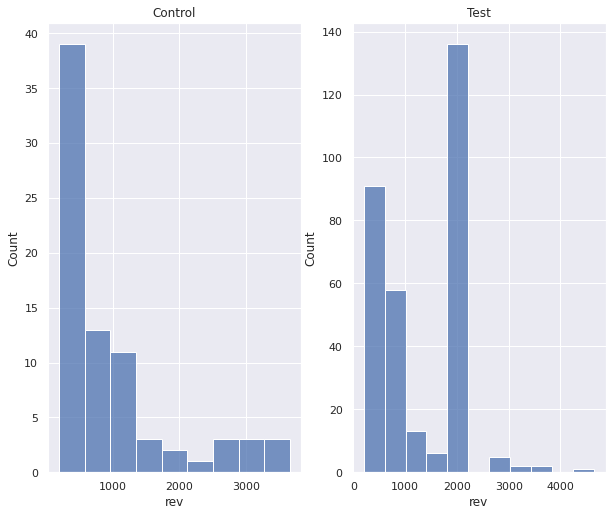

In [30]:
#вначале посмотрим на распределение данных, ввиду большого количества пользователей, 
#которые ничего не купили, оставим только пользователей с покупкой > 0
sns.set(rc={'figure.figsize':(10,8.27)})
fig, ax =plt.subplots(1,2)
sns.histplot(df_control[df_control['rev'] != 0].rev, ax=ax[0]).set_title('Control')
sns.histplot(df_test[df_test['rev'] != 0].rev, ax=ax[1]).set_title('Test')
fig.show()

Как мы видим, распределения достаточно похожи, однако, в тестовой выборке появилось аномальное количество пользователей с покупкой равной примерно 2000. Попробуем понять причину данной аномалии

In [31]:
table_contr = pd.DataFrame(df_control[df_control['rev'] != 0].rev.value_counts())
table_test = pd.DataFrame(df_test[df_test['rev'] != 0].rev.value_counts())

df1_styler = table_contr.style.set_table_attributes("style='display:inline'").set_caption('Control')
df2_styler = table_test.style.set_table_attributes("style='display:inline'").set_caption('Test')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,rev
290.0,25
580.0,6
990.0,5
590.0,5
199.0,5
690.0,4
1530.0,3
3660.0,3
840.0,3
1140.0,2


Как видно из таблиц, самая популярная величина покупки в тестовой группе составляет 1900 (128 пользователей), вторая по популярности 290 (45 пользователей). При этом в контрольной группе нет ни одного значения близкого к 1900. С большой долей вероятности можно судить, что в рамках эксперимента произошла какая-то ошибка. Сложно представить, что введение нового механизма оплаты привело бы к появлению новой когорты пользователей с определенной величиной покупки. Скорее всего при проведения эксперимента тестовой группе был показан новый товар стоимостью 1900 (в контрольной группе данного товара не было) либо тестовой группе была предложена новая акция.

**Таким образом, с большой долей вероятности делаем вывод, что эксперимент был проведен с ошибкой.**

Если есть возможность, эксперимент следует повторить. Однако, представим, что такая возможность отсутствует.

Попробуем нивелировать данное упущение. Если обнулить величину покупки у пользователей в тестовой группе, сумма покупки которых равна 1900, то изменение будет слишком велико (в тестовой группе обнулиться более половины пользователей). Попробуем присвоить данным пользователям среднюю величину покупки покупателей (т.е. среднюю величину у тех, кто купил что-то, а не среднюю величину от всех пользователей). Так, по крайней мере, конверсия в тестовой группе в результате наших преобразований не изменится. Отметим также, что ввиду вынужденных преобразований конверсия, которая не претерпела изменения, становится самой важной метрикой при подведении выводов в дальнейшем.

In [32]:
mean_test_corr = np.mean(df_test[df_test['rev']!=0].rev) #при подсчете среднего будем учитывать 
#всех покупателей, включая покупателей с суммой покупки 1900 (следует учесть, что данные пользователи 
#были готовы потратить данную сумму). 
mean_test_corr #находим среднее значение покупки у покупателей

1257.8789920382164

In [33]:
df_test_1900 = df_test.query('rev == 1900 or rev == 1900.0001')
df_test_1900.rev = mean_test_corr
df_test_1900.head(1) #присвоим пользователям с значениям покупки 1900 среднее значение покупки
#у покупателей в тестовой группе

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,grp,rev
67,3354191,B,1257.878992


In [34]:
df_test_corr = df_test.query('rev != 1900 and rev != 1900.0001')
df_test_new = pd.concat([df_test_corr, df_test_1900])
df_test_new.shape #проверяем, что не потеряли данных при преобразовании

(6803, 3)

In [35]:
#пересчитаем конверсию и ARPU
df_control_conv = len(df_control[df_control['rev'] != 0])/len(df_control)
df_test_conv_corr = len(df_test_new[df_test_new['rev'] != 0])/len(df_test_new)

df_control_ARPU = df_control.rev.sum()/ df_control.id.nunique()
df_test_ARPU_corr = df_test_new.rev.sum()/ df_test_new.id.nunique()

#рассчитаем также ARPPU
df_control_ARPPU = df_control.rev.sum()/ len(df_control[df_control['rev'] != 0])
df_test_ARPPU_corr = df_test_new.rev.sum()/ len(df_test_new[df_test_new['rev'] != 0])

df_metrics = pd.DataFrame(np.array([['Control',round(df_control_conv,3), 
                                     round(df_control_ARPU,1),
                                     round(df_control_ARPPU,1)], 
                                     ['Test',round(df_test_conv_corr,3),
                                     round(df_test_ARPU_corr,1),
                                     round(df_test_ARPPU_corr,1)]]),
                          columns=['grp', 'CR', 'ARPU', 'ARPPU'])
df_metrics

,grp,CR,ARPU,ARPPU
0,Control,0.051,47.3,933.6
1,Test,0.046,46.0,996.1


В результате отмечаем снижение по результатам эксперимента конверсии и ARPU, и увеличение ARPPU.

Далее оценим статистическую значимость полученных изменений

**CR**

Переменная в конверсии - категориальная. Соответственно, в качестве статистического теста используем - кси-квадрат, который достаточно прост в расчете.

Условия проведения теста кси-квадрат:

1) Все переменные незавизимы, - соблюдается (в нашем случае мы анализизируем конверсию независимых пользователей);

2) Количество наблюдений в каждой ячейке сопряженной таблицы > 5, - соблюдается (с учетом конверсии 5% меньше 5 значений не будет ни в одной из ячеек).

Для дальнейшего ориентира применим 5% уровень значимости.

In [36]:
#рассчитаем данные по конверсии необходимые для теста
control_1 = len(df_control[df_control['rev'] > 0])
control_0 = df_control.shape[0] - control_1
test_1 = len(df_test[df_test['rev'] > 0])
test_0 = df_test.shape[0] - test_1

T = np.array([[control_1, control_0], [test_1, test_0]])

In [37]:
import scipy
from scipy import stats
scipy.stats.chi2_contingency(T,correction=False)[1]#поправка Йетса не требуется - значения в ячейках > 10

0.44547028437158964

Полученное p-value больше выбранного уровня значимости в 5%, соответственно, принимаем нулевую гипотезу, **конверсия контрольной и тестовой групп не отличается.**

**ARPU, ARPPU**

Переменные - ARPU, ARPPU - непрерывные. Соответственно, предварительный план на исследование следующий:

1) проведем проверку на нормальность данных метрик методом бутстрепа; - с учетом размера выборок (> 1000), для ускорения работы можно применить пуассоновский бутстрап

2) если проверка проходит, проводим t-тест Уэлча (тест, который не требует равенство внутригрупповых дисперсий в выборках);

3) если проверки не проходят, проводим бутстреп тест (симуляция Монте-Карло);

Логарифмирование и метод Манна-Уитни проводить не планируется ввиду сложноинтерпретируемости результатов данных тестов (к примеру, в тесте Манна-Уитни сравниваются ранги выборок, а не метрики). К тому же, как мы убедились, в наших выборках величина покупок пользователей сильно варьируется (при этом высокие значения покупок не являются выбросами). Соответственно, при ранжировании/логарифмировании величины покупок сгладится разница между самыми низкими и высокими значениями. Таким образом, возможна ситуация, когда ранжированная выборка покажет повышение показателя, хотя, фактически произошло снижение (добавилось много пользователей с низкой покупкой, но при этом ушло несколько пользователей с очень высокими покупками, что перекрыло эффект от новых пользователей).

Для дальнейшего ориентира применим 5% уровень значимости.

In [38]:
from tqdm.notebook import trange, tqdm

In [39]:
#сформируем выборки ARPU из тестовой и контрольной групп используя пуассоновский бутстрап
np.random.seed(14)
sample_ARPU_control = []
sample_ARPU_test = []
for _ in trange(1000):
    puas_control = np.random.poisson(1,len(df_control))
    puas_test = np.random.poisson(1,len(df_test_new))
    sample_ARPU_control.append(sum(df_control['rev']*puas_control)/len(df_control))
    sample_ARPU_test.append(sum(df_test_new['rev']*puas_test)/len(df_test_new))   

In [40]:
#сформируем выборки ARPPU из тестовой и контрольной групп
np.random.seed(17)
sample_ARPPU_control = []
sample_ARPPU_test = []
for _ in trange(1000):
    df_control['puas'] = np.random.poisson(1,len(df_control))
    df_test_new['puas'] = np.random.poisson(1,len(df_test_new))
    df_control['sum_rev'] = df_control['rev']*df_control['puas']
    df_test_new['sum_rev'] = df_test_new['rev']*df_test_new['puas']
    sample_ARPPU_control.append(sum(df_control['sum_rev'])
                                /sum(df_control[df_control['sum_rev'] != 0].puas))
    sample_ARPPU_test.append(sum(df_test_new['sum_rev'])
                             /sum(df_test_new[df_test_new['sum_rev'] != 0].puas))

df_control = df_control[['id', 'grp', 'rev']] #возвращаем ДФ в исходное состояние
df_test_new = df_test_new[['id', 'grp', 'rev']] 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

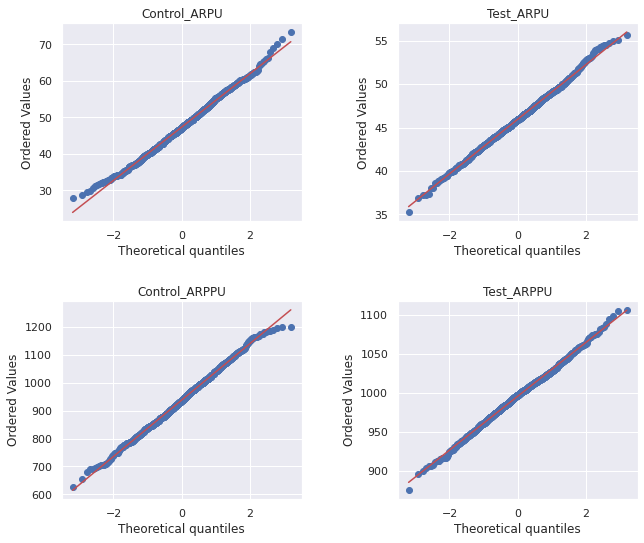

In [41]:
#Проверим нормальность распределений ARPU и ARPPU на графике QQ-plot
import numpy as np  
import scipy.stats as stats

ax1 = plt.subplot(221)
res = stats.probplot(sample_ARPU_control, dist="norm", plot=plt)
ax1.set_title("Control_ARPU")
ax2 = plt.subplot(222)
res = stats.probplot(sample_ARPU_test, dist="norm", plot=plt)
ax2.set_title("Test_ARPU")
ax3 = plt.subplot(223)
res = stats.probplot(sample_ARPPU_control, dist="norm", plot=plt)
ax3.set_title("Control_ARPPU")
ax4 = plt.subplot(224)
res = stats.probplot(sample_ARPPU_test, dist="norm", plot=plt)
ax4.set_title("Test_ARPPU")
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.show()

Как видно из графиков, все линии лежат близко к линии нормального распределения (45-градусная линия), что говорит о близости к нормальному распределений в выборках ARPU, ARPPU контрольной и тестовой групп. Однако, целесообразно провести дополнительную проверку на нормальность методом Шапиро-Уилка

In [42]:
#дополнительно, проверим на нормальность расределений методом Шапиро-Уилка
sp = stats.shapiro(sample_ARPU_control)
print('Тест на нормальность ARPU_control: p-value = %.3f' % sp[1])

sp = stats.shapiro(sample_ARPU_test)
print('Тест на нормальность ARPU_test: p-value = %.3f' % sp[1])

sp = stats.shapiro(sample_ARPPU_control)
print('Тест на нормальность ARPPU_control: p-value = %.3f' % sp[1])

sp = stats.shapiro(sample_ARPPU_test)
print('Тест на нормальность ARPPU_test: p-value = %.3f' % sp[1])

Тест на нормальность ARPU_control: p-value = 0.034
Тест на нормальность ARPU_test: p-value = 0.531
Тест на нормальность ARPPU_control: p-value = 0.152
Тест на нормальность ARPPU_test: p-value = 0.411


Таким образом, нормальность распределения не подтверждается только для контрольной выборки ARPU (p-value<0.05). Соответственно, в рамках приведенного выше плана на исследование, статистическую значимость разницы ARPU 
между контрольной и тестовой выборкой оценим бутстрап методом, который позволяет не обращать внимание 
на распределение метрики. Для метрики ARPPU применим менее громоздкий t-тест Уэлча.

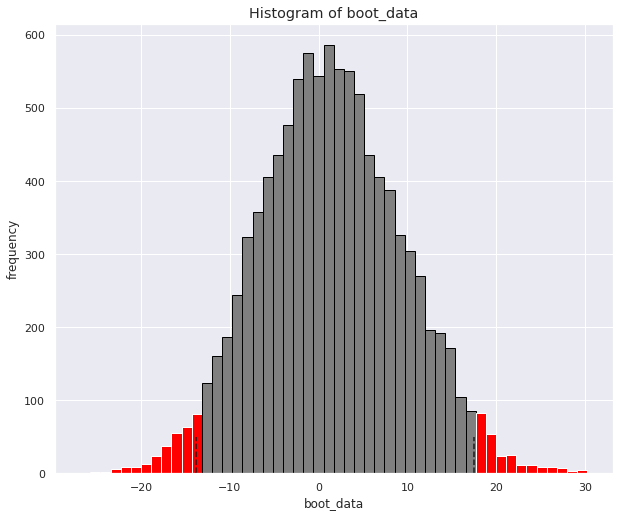

In [43]:
#оценим статистическую значимость разницы ARPU методом бутстрап. Принимаем 95% доверительный интервал.

#извлечем выборку разниц ARPU тестовой и контрольной выборок
boot_data = []
for _ in trange(10000): # извлекаем подвыборки
    samples_1 = df_control.sample(len(df_control), 
                replace = True) # повтор значений разрешается (суть бутстрепа)
        
    samples_2 = df_test_new.sample(len(df_test_new), 
                                   replace = True)
            
        
    ARPU_control = sum(samples_1.rev)/len(samples_1)
    ARPU_test = sum(samples_2.rev)/len(samples_2)
        
    boot_data.append(ARPU_control-ARPU_test)

pd_boot_data = pd.DataFrame(boot_data)

#рассчитаем границы доверительного интервала        
left_quant = (1 - 0.95)/2
right_quant = 1 - (1 - 0.95) / 2
quants = pd_boot_data.quantile([left_quant, right_quant])

#рассчитаем p-value 
p_1 = scipy.stats.norm.cdf(x = 0, loc = np.mean(boot_data), 
                           scale = np.std(boot_data))
p_2 = scipy.stats.norm.cdf(x = 0, loc = -np.mean(boot_data), 
                           scale = np.std(boot_data))

p_value = min(p_1, p_2) * 2

# Построим гистограмму бутстрап распределения с нанесенными границами 
#доверительного интервала
_, _, bars = plt.hist(pd_boot_data[0], bins = 50)
for bar in bars:
    if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
        bar.set_facecolor('red')
    else: 
        bar.set_facecolor('grey')
        bar.set_edgecolor('black')
    
plt.style.use('ggplot')
plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.title("Histogram of boot_data")
plt.show()

Как видно на гисторграмме, 0 входит в диапазон доверительно интервала. Таким образом, делаем вывод, что разница между ARPU контрольной и тестовой групп **статистически не значима.**

In [44]:
#Проведем проверку равенства метрик ARPPU t-тестом Уэлча
df_t_control = df_control[df_control['rev'] != 0].rev
df_t_test = df_test_new[df_test_new['rev'] != 0].rev
_, p = stats.ttest_ind(df_t_control, df_t_test, equal_var=False,
                      alternative = 'less') #альтернативная гипотеза в том, 
                                            #что метрика в контрольной группе меньше чем в тестовой
p

0.2854098127646194

По итогом теста получаем, что p-value > 0.05. Таким образом, делаем вывод, что разница между ARPPU контрольной и тестовой групп **статистически не значима.**

**ВЫВОД ПО РЕЗУЛЬТАТАМ ИССЛЕДОВАНИЯ**

*В результате анализа данных было получены следующие заключения:*

1) С большой долей вероятности эксперимент был проведен с ошибкой, кроме новой механики оплаты тестовой группе был предложен новый продукт либо новая акция стоимостью 1900, кроме того, соотношение контрольной и целевой группы составляет 80/20, что также не является оптимальным;

2) Ни по одной из выбранных целевых метрик (CR - основная метрика, ARPU, ARPPU) не наблюдается статистически значимое увеличение.

*С учетом вышеуказанного предлагается:*

1) Если есть возможность, провести эксперимент повторно. При этом следует убедиться в отсутствии факторов влияния кроме новой механики оплаты на тестовую группу. Дополнительно, предлагается обеспечить соотношение тестовой и контрольной группы 50/50;

2) Если возможность провести эксперимент повторно отсутствует, **предлагается не применять на всех пользователей новую механику оплаты.**

**Задача 2. SQL**

*Очень усердные ученики*

Условие:

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. (под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц)

*Данные*

default.peas:

- st_id	(int) -	ID ученика
- timest	(timestamp)	- Время решения карточки
- correct	(bool)	- Правильно ли решена горошина?
- subject	(text)	-Дисциплина, в которой находится горошина

Импортируем библиотеку для работы с Clickhouse, настраиваем подключение, пишем функцию подгрузки данных по запросу

In [45]:
import pandahouse as ph

In [46]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [47]:
def select(sql):
    '''функция подключения'''
    return ph.read_clickhouse(sql, connection=connection_default)

In [48]:
#посмотрим на рассмотрение студентов по месяцам
query = """
SELECT 
    MONTH(CAST(timest, 'Date')) as last_MONTH, COUNT(DISTINCT(st_id))
FROM default.peas
GROUP BY MONTH(CAST(timest, 'Date'))
"""
select(query)

,last_MONTH,uniqExact(st_id)
0,10,308


В таблице присутствуют данные всего по одному месяцу, т.е. он и есть текущий. Соответственно, далее можно написать запрос с поиском усердных студентов без указания условия по месяцу

In [49]:
#посмотрим как обозначаются правильные ответы в таблице
query = """
SELECT distinct(correct)
FROM default.peas
"""
select(query)

,correct
0,1
1,0


In [50]:
#с учетом вышеуказанного запрос можно написать следующим образом
query = """
SELECT 
    COUNT(st_id)
FROM
(
SELECT 
    st_id, SUM(correct) AS corr_num
FROM default.peas
GROUP BY st_id
HAVING corr_num >= 20
)
"""
select(query)

,count(st_id)
0,136


**ОТВЕТ: За текущий месяц было 136 успешных учеников.**

*Оптимизация воронки*

Образовательная платформа предлагает пройти студентам курсы по модели trial: 
студент может решить бесплатно лишь 30 горошин в день. 
Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. 
Команда провела эксперимент, где был протестирован новый экран оплаты.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

**Задача**

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.


**Данные:**

default.peas:

- st_id	(int) -	ID ученика
- timest	(timestamp)	- Время решения карточки
- correct	(bool)	- Правильно ли решена горошина?
- subject	(text)	-Дисциплина, в которой находится горошина

default.studs:

- st_id	(int) 	- ID ученика
- test_grp	(text) -	Метка ученика в данном эксперименте


default.final_project_check:

- st_id	(int) - ID ученика
- sale_time	(timestamp)	- Время покупки
- money	(int)	- Цена, по которой приобрели данный курс
- subject	(text) 	- Дисциплина, на которую приобрели полный доступ

In [51]:
query = '''
SELECT test_grp,
    ROUND(SUM(money_sum) / COUNT(st_id)) AS ARPU,
    ROUND(sumIf(money_sum, correct_tasks > 10) / SUM(is_active)) AS ARPAU,
    ROUND(SUM(is_buy) / COUNT(st_id), 3) AS CR,
    ROUND(SUM(is_active_buy) / SUM(is_active), 3) AS CR_act,
    ROUND(SUM(is_math_buy) / SUM(is_active_math), 3) AS CR_act_math
FROM
    (SELECT stud.st_id AS st_id,
        test_grp,
        correct_tasks,
        money_sum,
        IF(correct_tasks > 10 , 1, 0) AS is_active,
        IF(money_sum > 0, 1, 0) AS is_buy,
        IF(correct_tasks > 10 and money_sum > 0, 1, 0) AS is_active_buy,
        IF(correct_tasks_math >= 2, 1, 0) AS is_active_math,
        IF(correct_tasks_math >= 2 and money_sum_math > 0, 1, 0) AS is_math_buy
    FROM default.studs stud
    LEFT JOIN
        (SELECT st_id,
            SUM(correct) AS correct_tasks,
            sumIf(correct, subject=='Math') AS correct_tasks_math
        FROM default.peas
        GROUP BY st_id
        ) p ON p.st_id = stud.st_id
    LEFT JOIN
        (SELECT st_id,
            SUM(money) AS money_sum,
            sumIf(money, subject == 'Math') AS money_sum_math
        FROM default.final_project_check
        GROUP BY st_id
        ) c ON p.st_id = c.st_id
    GROUP BY st_id,
            test_grp,
            correct_tasks,
            money_sum,
            money_sum_math,
            correct_tasks_math)
GROUP BY test_grp
'''
#выведем ответ по заданию
print('ОТВЕТ:')
select(query)

ОТВЕТ:


,test_grp,ARPU,ARPAU,CR,CR_act,CR_act_math
0,control,4541.0,10394.0,0.049,0.11,0.061
1,pilot,11068.0,29740.0,0.102,0.26,0.095


**Задание 3. Python**

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [52]:
#за основу возьмем ячейку в блоке задания по A/B тесту, где рассчитывалась таблица с метриками
#требуется добавить обновление метрик.
#по условию не уточняются нужно ли обновлять датафрейм с контрольной и тестовой группами
#предположим, что эти данные не должны обновляться
def add_data(path):
    """
    Переименование колонок, обновление данных, пересчет метрик
    На вход принимает датафрейм с колонками id, группа (grp) и доход (rev)
    На выход функция выдает таблицу с обновленными метриками CR,ARPU,ARPPU
    
    """
    global df_control
    global df_test_new
    
    df_control_1 = df_control.copy()
    df_test_1 = df_test_new.copy()
    
    #считываем данные
    dataframe = pd.read_csv(path, sep=';')

    #переименовываем колонки
    dataframe = dataframe.rename(columns = {dataframe.columns[0]: "id",
                                            dataframe.columns[1]: "grp",
                                            dataframe.columns[2]: "rev"})
    
    
    #приводим в нужный формат значения в колонках    
    dataframe = dataframe.astype({dataframe.columns[0]: 'int',
                                dataframe.columns[1]: 'str',
                                dataframe.columns[2]: 'float'})
    
    df_control_1 = df_control_1.astype({df_control_1.columns[0]: 'int',
                                df_control_1.columns[1]: 'str',
                                df_control_1.columns[2]: 'float'})
    
    df_test_1 = df_test_1.astype({df_test_1.columns[0]: 'int',
                                df_test_1.columns[1]: 'str',
                                df_test_1.columns[2]: 'float'})
    
    #выделяем отдельно тестовую и контрольную выборки
    dataframe_control = dataframe[dataframe['grp'] == 'A']
    dataframe_test = dataframe[dataframe['grp'] == 'B']     
    
    #добавляем в контрольную и тестовую выборки новые данные
    df_control_1 = df_control_1.append(dataframe_control)
    df_test_1 = df_test_1.append(dataframe_test)
        
    #пересчитаем метрики и построим новую таблицу    
    df_control_conv = len(df_control_1[df_control_1['rev'] != 0])/len(df_control_1)
    df_test_conv_corr = len(df_test_1[df_test_1['rev'] != 0])/len(df_test_1)
    
    df_control_ARPU = df_control_1.rev.sum()/ df_control_1.id.nunique()
    df_test_ARPU_corr = df_test_1.rev.sum()/ df_test_1.id.nunique()

    df_control_ARPPU = df_control_1.rev.sum()/ len(df_control_1[df_control_1['rev'] != 0])
    df_test_ARPPU_corr = df_test_1.rev.sum()/ len(df_test_1[df_test_1['rev'] != 0])

    df_metrics = pd.DataFrame(np.array([['Control',round(df_control_conv,3), 
                                         round(df_control_ARPU,1),
                                         round(df_control_ARPPU,1)], 
                                         ['Test',round(df_test_conv_corr,3),
                                         round(df_test_ARPU_corr,1),
                                         round(df_test_ARPPU_corr,1)]]),
                              columns=['grp', 'CR', 'ARPU', 'ARPPU'])
    return df_metrics

In [53]:
df_metrics #для ориентира изначальное значение метрик

,grp,CR,ARPU,ARPPU
0,Control,0.051,47.3,933.6
1,Test,0.046,46.0,996.1


In [55]:
#протестируем функцию
#предположим требуется добавить следующий ДФ к данным
path = 'groups_add.csv'
df = pd.read_csv(path,sep=';')
df 

,student_id,grp,rev
0,1627,A,990.0
1,3185,A,690.0
2,25973,A,690.0
3,26280,A,690.0
4,100300,A,990.0
...,...,...,...
536,5645737,B,1900.0
537,5651566,B,1900.0
538,5662322,B,1900.0
539,5681918,B,1900.0


In [56]:
#Запускаем и смотрим обновились ли метрики
add_data(path)

,grp,CR,ARPU,ARPPU
0,Control,0.131,133.9,1010.4
1,Test,0.099,106.1,1033.2


Функция работает 

In [57]:
def draw_metrics(metrics):
    """
    Вывод графиков метрик CR, ARPU, ARPPU
    на вход подается ДФ со столбцами grp, CR,ARPU,ARPPU
    на выходе функции выводятся графики метрик
    """
    metrics = metrics.astype({metrics.columns[0]: 'str',
                                    metrics.columns[1]: 'float',
                                    metrics.columns[2]: 'float',
                                    metrics.columns[3]: 'float'})

    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('A/B test metrics comparison', size='x-large', weight='heavy', y=1.03)

    sns.barplot(ax=axes[0], x=metrics.grp, y=metrics.CR).set(xlabel=None,ylabel=None)
    axes[0].set_title('CR')

    sns.barplot(ax=axes[1], x=metrics.grp, y=metrics.ARPU).set(xlabel=None,ylabel=None)
    axes[1].set_title('ARPU')

    sns.barplot(ax=axes[2], x=metrics.grp, y=metrics.ARPPU).set(xlabel=None,ylabel=None)
    axes[2].set_title('ARPPU')

    plt.show()   

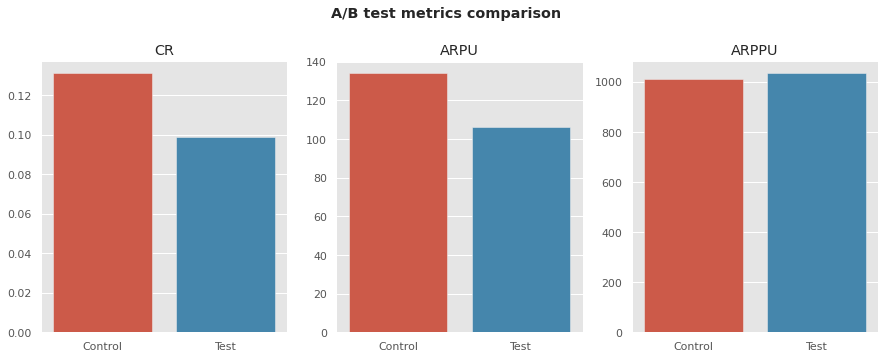

In [58]:
#протестируем наши функции
draw_metrics(add_data(path))

По итогу функции отработали штатно